## In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reference paper

Wavelet Neural Network(WNN)
- https://www.researchgate.net/publication/237036240_EOG_Artifact_Removal_using_a_Wavelet_Neural_Network

## Reference for the data
- https://data.mendeley.com/datasets/wb6yvr725d/4

    - EEG electrodes (Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, T6, Fz, Cz, Pz) were placed according to the 10–20 International System,
    - Sampling frequency = 200 Hz
    - Bandpass filter at 0.5-40Hz
    - Notch filter at 50 Hz
    - Each dataset has 30 seconds duration
    - OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

## Select 1st dataset (54 subjects * each has 19 EEG channels + 2 EOG channels)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io
import scipy.signal
import seaborn as sns; sns.set_style("darkgrid") # styling
import pywt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.callbacks import CSVLogger

number_subjects = 54
initial_fs = 200
EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

initial_pure_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Pure_Data.mat")
initial_cont_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Contaminated_Data.mat")
initial_HEOG = scipy.io.loadmat("Datasets/semi_EEG-EOG/HEOG.mat")
initial_VEOG =scipy.io.loadmat("Datasets/semi_EEG-EOG/VEOG.mat")

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

### Calculte FFT
def next_pow2(x):
    return 1<<(x-1).bit_length()

def calculate_FFT(inputSignal, fs, n_zeropad=0, window="False", timescaling=1):
    
    my_signal = inputSignal.copy()
    
    if window != "False":
        window = get_window(window, inputSignal.shape[0])
        my_signal *= window # multiply signal by window to reduce fluctuation in frequency-domain
        
    time_zeropadding =  np.hstack((my_signal, np.zeros(int(n_zeropad)))) # zero-padding in time-domain
    nfft = time_zeropadding.shape[0]           # get the number of samples in the signal
#     nfft = next_pow2(nfft)                                     # FFT is more efficient when using number of samples is part of power of 2
    fft = np.fft.fft(my_signal,nfft)[:int(np.ceil(nfft/2))]             # extract only the 1st half of the result (one-side frequency
    fft = fft*2                                                # multiply magnitude by 2 after select only one-side frequency
    corr_mag_fft = np.abs(fft)/nfft * (nfft / my_signal.shape[0]) / timescaling

    df = fs/nfft                                   # finding frequency resolution
    xfft = np.arange(0, fs/2,df)                   # correcting x-axis
    
    return xfft, corr_mag_fft

In [ ]:
def ExtractOnlyEEG(dict_inputEEG):
    outputEEG = dict()
    for key, value in dict_inputEEG.items():
        if key not in ['__header__', '__version__', '__globals__']:
            outputEEG[key] = value
    return outputEEG

extracted_pure_eeg = ExtractOnlyEEG(initial_pure_dataset)
extracted_cont_eeg = ExtractOnlyEEG(initial_cont_dataset)
extracted_HEOG = ExtractOnlyEEG(initial_HEOG)
extracted_VEOG = ExtractOnlyEEG(initial_VEOG)

def findMinumumEEGLength(dict_inputEEG):
    minEEGLength = int()
    for idx, eeg_values in enumerate(dict_inputEEG.values()):
        EEGLength = eeg_values.shape[-1]
        if idx == 0:
            minEEGLength = EEGLength
        elif minEEGLength > EEGLength:
            minEEGLength = EEGLength
    return minEEGLength

minEEGLength = findMinumumEEGLength(extracted_cont_eeg)
print(f"Minumum EEG length: {minEEGLength}")

# sampling frequency = 200 Hz and 26 seconds
selectedEEGLength = 200 * 26
print(f"Selected EEG length: {selectedEEGLength}")

Minumum EEG length: 5401
Selected EEG length: 5200


In [ ]:
def SelectLengthChannel(dict_inputEEG, selectEEGLength):
    """
    selectEEGChannel get an index according to the data's channels information like Fp1 = '0'
    """
    dict_oneChannelEEG = dict()
    for key, value in dict_inputEEG.items():
        dict_oneChannelEEG[key] = value[:, :selectEEGLength]
    return dict_oneChannelEEG

selectedLength_pureEEG = SelectLengthChannel(dict_inputEEG=extracted_pure_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_contEEG = SelectLengthChannel(dict_inputEEG=extracted_cont_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_HEOG = SelectLengthChannel(dict_inputEEG=extracted_HEOG,
                                              selectEEGLength=selectedEEGLength)
selectedLength_VEOG = SelectLengthChannel(dict_inputEEG=extracted_VEOG,
                                              selectEEGLength=selectedEEGLength)

print(f"Number of subjects: {len(list(extracted_pure_eeg.keys()))}")
print(f"The number of samples of contaminated EEG in one subject: {selectedLength_contEEG['sim1_con'].shape}")

Number of subjects: 54
The number of samples of contaminated EEG in one subject: (19, 5200)


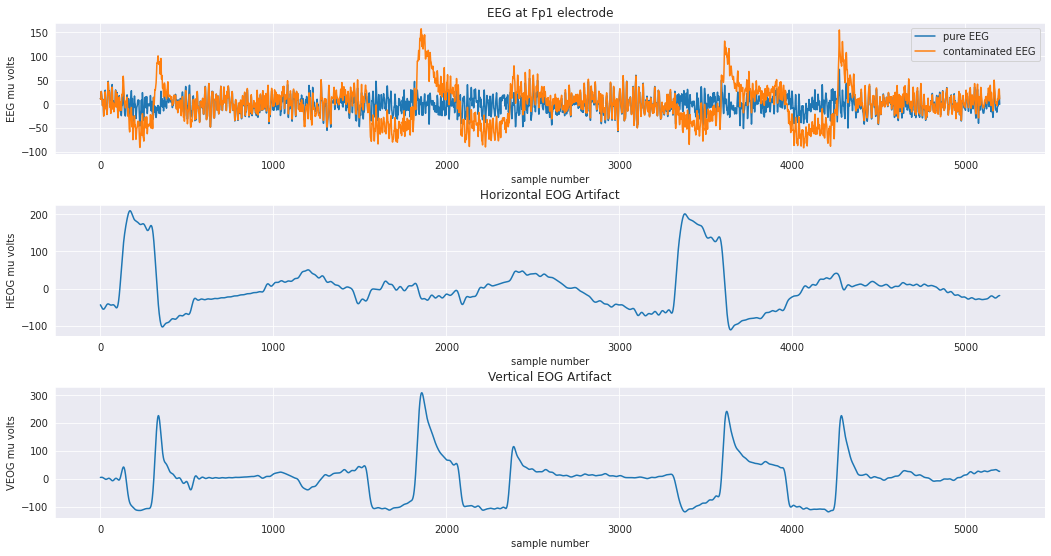

In [ ]:
index_selected_electrode = 0

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(selectedLength_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(selectedLength_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

# SRGAN

In [ ]:
def scaling_eeg(inputs, max_bf, min_bf, max_af, min_af):
    """
    Scaling eeg with the relative value accord multiple channels
    Think about the amplitude between the maximum values of 
    eye blink at Fp1 and normal eeg signal at Oz

    max_af = maximum value in inputs after normalize
    min_af = minimum value in inputs after normalize
    max_bf = maximum value in inputs before normalize
    min_bf = minimum value in inputs before normalize
    """ 
    scaled_inputs = ((max_af - min_af) * (inputs - min_bf) / (max_bf - min_bf)) + min_af
    scaler = [max_bf, min_bf, max_af, min_af]
    return scaled_inputs, scaler

def descaling_eeg(scaled_inputs, scaler):
    max_bf, min_bf, max_af, min_af = scaler
    de_scaled_inputs = ((scaled_inputs - min_af) * (max_bf - min_bf) / (max_af - min_af)) + min_bf
    return de_scaled_inputs

In [ ]:
np_cont_eeg = []
np_pure_eeg = []

for key, value in selectedLength_contEEG.items():
    np_cont_eeg.append(value)
np_cont_eeg = np.array(np_cont_eeg)

for key, value in selectedLength_pureEEG.items():
    np_pure_eeg.append(value)
np_pure_eeg = np.array(np_pure_eeg)

# Scaling
scaled_cont_eeg, cont_scaler = scaling_eeg(np_cont_eeg, 
                                           max_bf=np.max(np_cont_eeg), min_bf=np.min(np_cont_eeg),
                                           max_af =1, min_af=-1)
scaled_pure_eeg, pure_scaler = scaling_eeg(np_pure_eeg, 
                                           max_bf=np.max(np_cont_eeg), min_bf=np.min(np_cont_eeg),
                                           max_af =1, min_af=-1)

# De-scaling
de_scaled_cont_eeg = descaling_eeg(scaled_cont_eeg, scaler=cont_scaler)
de_scaled_pure_eeg = descaling_eeg(scaled_pure_eeg, scaler=pure_scaler)

# Split
split_subjs = 40
train_cont_eeg = scaled_cont_eeg
eval_cont_eeg = scaled_cont_eeg
train_cleaned_eeg = scaled_pure_eeg
eval_cleaned_eeg = scaled_pure_eeg

# train_cont_eeg, scaler = scaling_eeg(np_cont_eeg[:split_subjs], max_af =1, min_af=-1)
# eval_cont_eeg = scaling_eeg(np_cont_eeg[split_subjs:], max_af =1, min_af=-1)
# train_cleaned_eeg = scaling_eeg(np_pure_eeg[:split_subjs], max_af =1, min_af=-1)
# eval_cleaned_eeg = scaling_eeg(np_pure_eeg[split_subjs:], max_af =1, min_af=-1)

In [ ]:
print(np.max(train_cont_eeg))
print(np.max(eval_cont_eeg))
print(np.max(train_cleaned_eeg))
print(np.max(eval_cleaned_eeg))

print(np.min(train_cont_eeg))
print(np.min(eval_cont_eeg))
print(np.min(train_cleaned_eeg))
print(np.min(eval_cleaned_eeg))

1.0
1.0
1.020086
1.020086
-1.0
-1.0
-0.9966336
-0.9966336


(5200,)
(5200,)


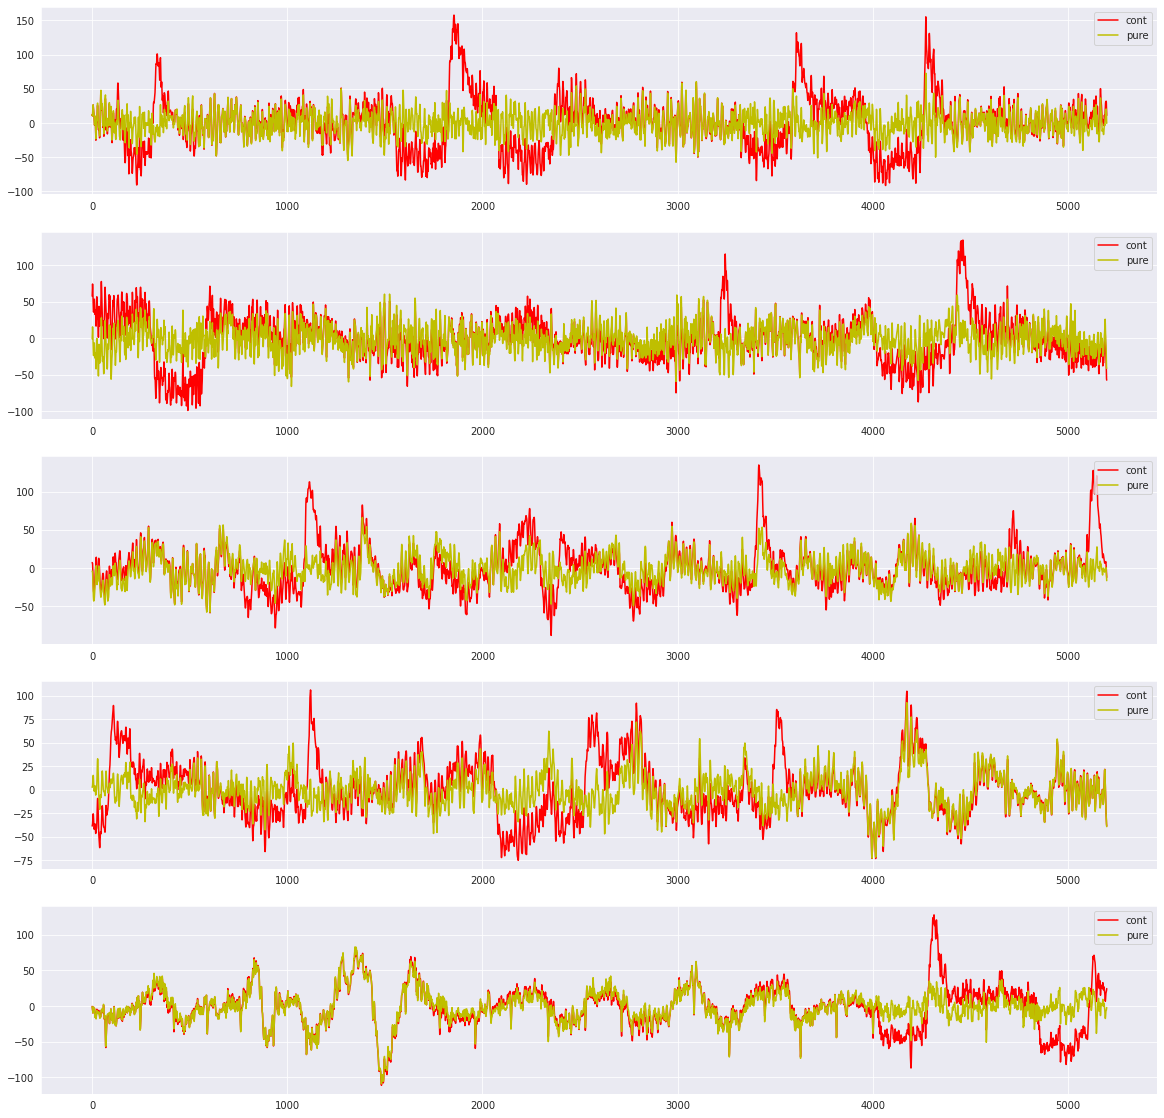

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = np_cont_eeg[idx_segment, idx_ch, :]
        e_pure = np_pure_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

(5200,)
(5200,)


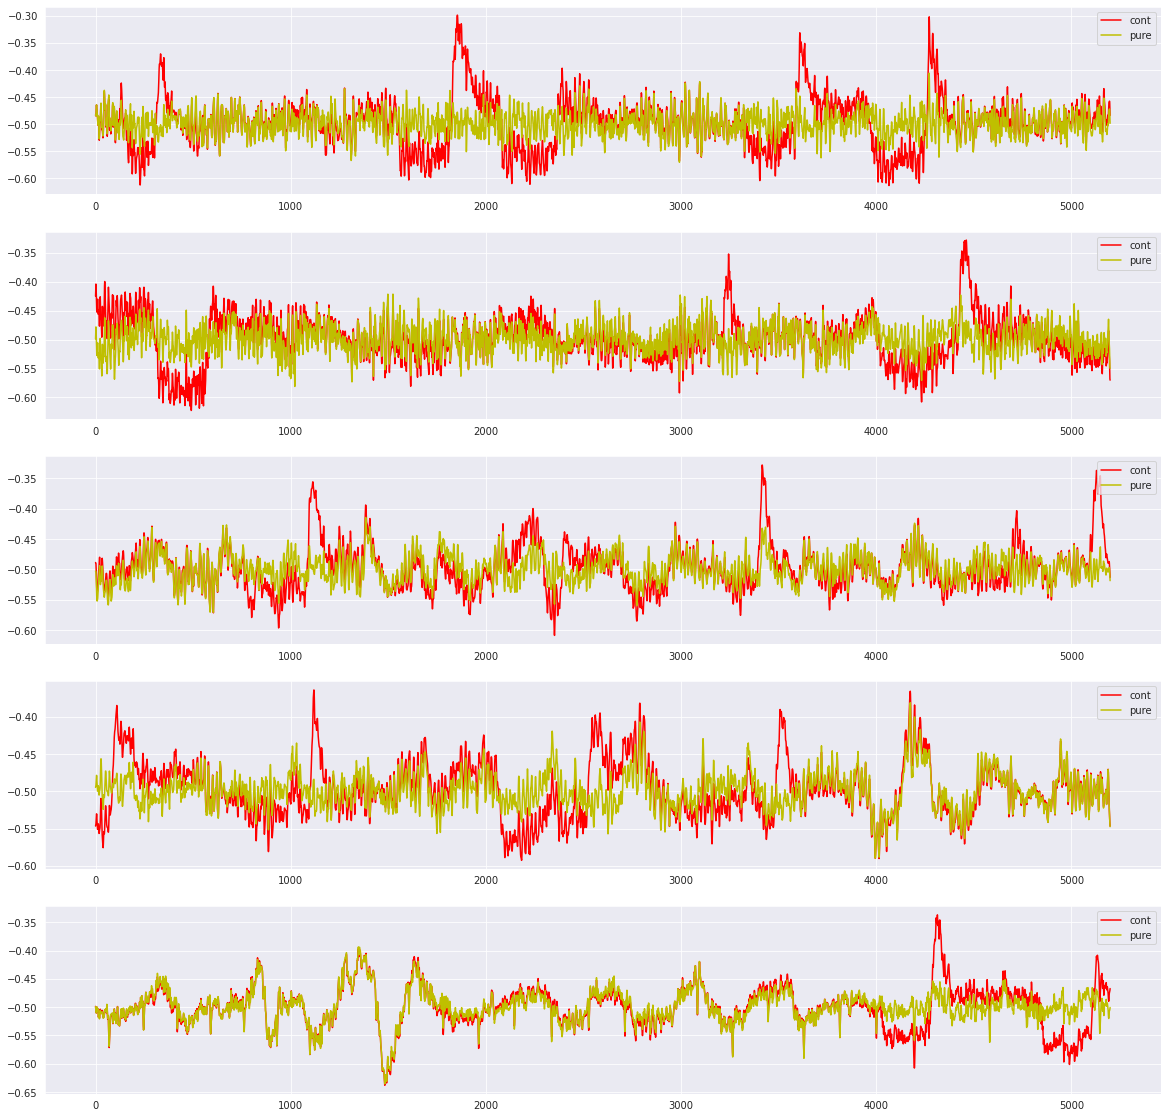

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = scaled_cont_eeg[idx_segment, idx_ch, :]
        e_pure = scaled_pure_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

(5200,)
(5200,)


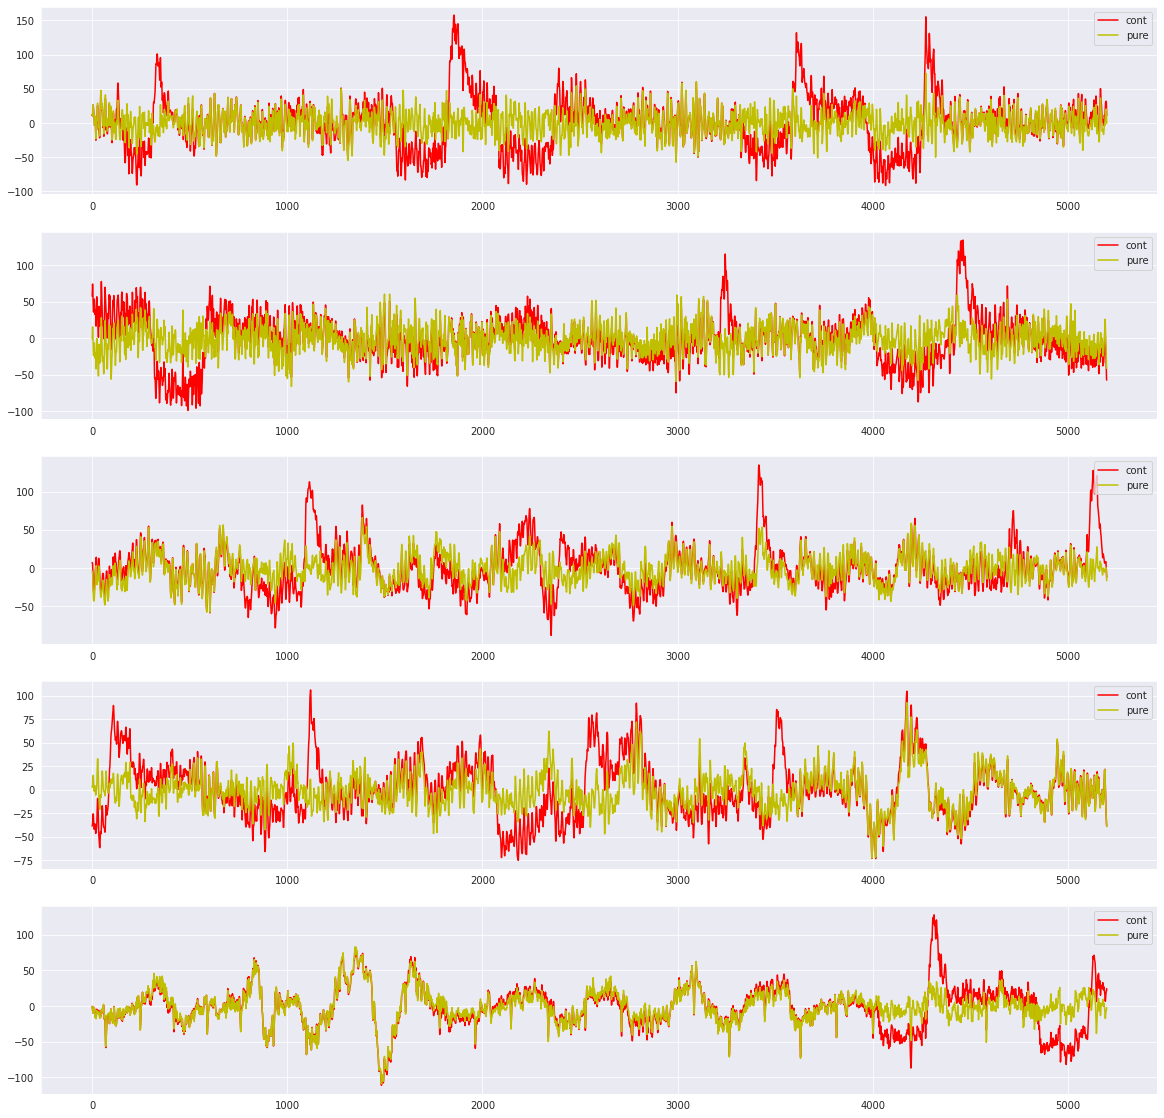

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = de_scaled_cont_eeg[idx_segment, idx_ch, :]
        e_pure = de_scaled_pure_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

In [ ]:
print(train_cont_eeg.shape)
print(eval_cont_eeg.shape)
print(train_cleaned_eeg.shape)
print(eval_cleaned_eeg.shape)

(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)
(54, 19, 5200)


(5200,)
(5200,)


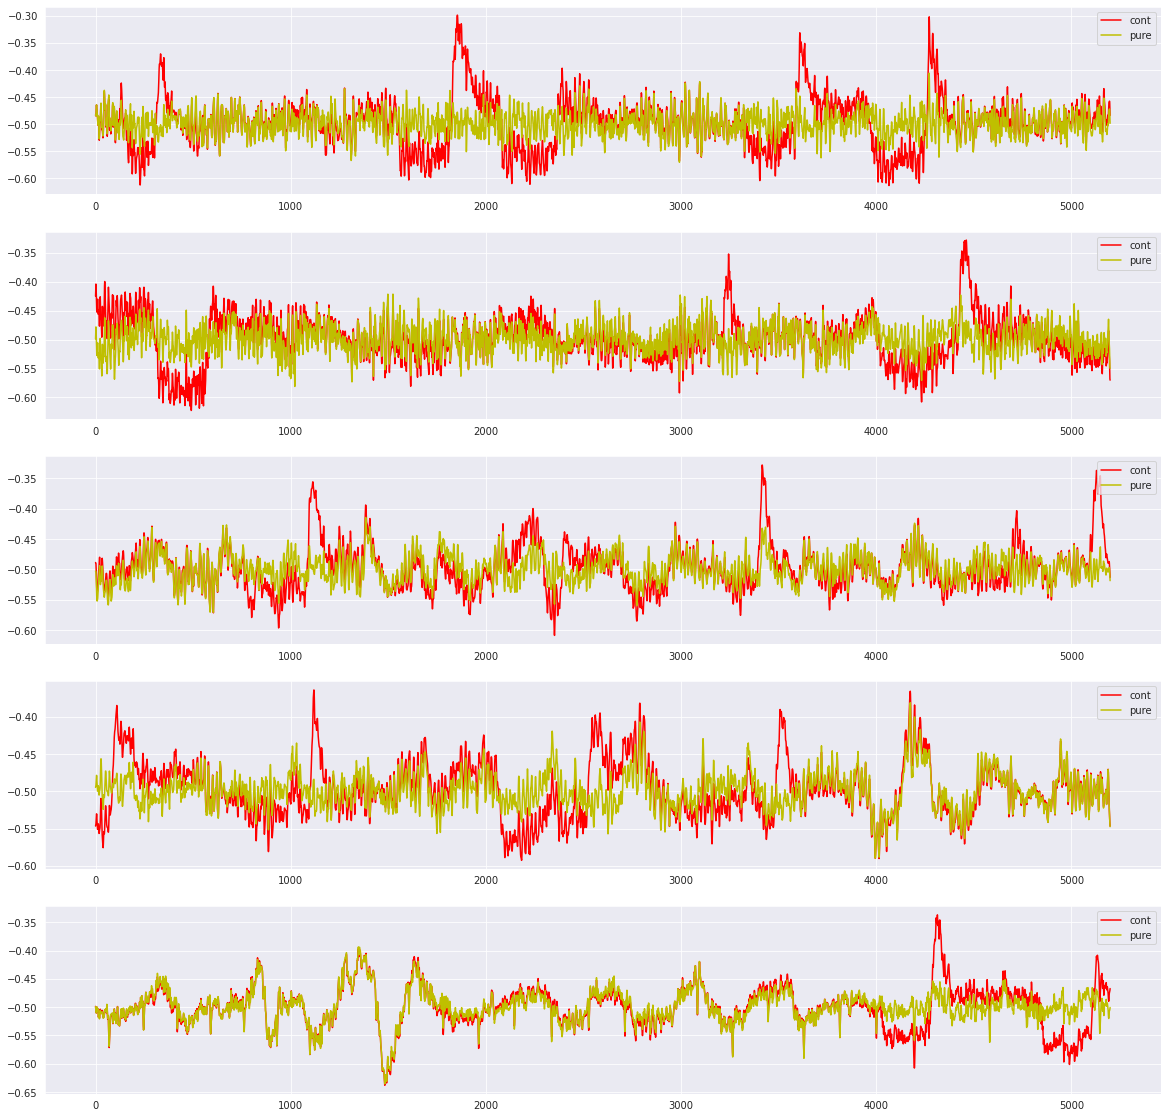

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = train_cont_eeg[idx_segment, idx_ch, :]
        e_pure = train_cleaned_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

In [ ]:
def segmentation(in_signals, new_seg_duration, sfreq):

    n_epochs = in_signals.shape[0]
    out_data = []
    # Possible segments per epoch
    pos_segs = in_signals.shape[-1] // (new_seg_duration * sfreq)

    for idx_e_epoch in range(n_epochs):
        for idx_e_seg in range(pos_segs):
            start_index = int(idx_e_seg * sfreq)
            end_index = int(start_index + sfreq)

            # Select a segment
            e_segment = in_signals[idx_e_epoch, :, start_index:end_index]
            # Append
            out_data.append(e_segment)

    return np.array(out_data)

In [ ]:
sfreq_after_epoch = initial_fs

# Segment each epoch into 1s segment
train_cont_1s_seg = segmentation(in_signals=train_cont_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
eval_cont_1s_seg = segmentation(in_signals=eval_cont_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
train_cleaned_1s_seg = segmentation(in_signals=train_cleaned_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
eval_cleaned_1s_seg = segmentation(in_signals=eval_cleaned_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)

In [ ]:
print(np.all(train_cont_1s_seg[0,:,0:200] == train_cont_eeg[0,:,0:200]))
print(np.all(train_cont_1s_seg[1,:,0:200] == train_cont_eeg[0,:,200:400]))
print(np.all(train_cont_1s_seg[28,:,0:200] == train_cont_eeg[1,:,400:600]))

True
True
True


In [ ]:
print(train_cont_1s_seg.shape)
print(eval_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)

(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)


### Implemetation of **Dataset class** 
(for DataLoader)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

from sklearn.preprocessing import MinMaxScaler

import scipy

import seaborn as sns

import os
import re

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, cont_eeg, clean_eeg):
        super(EEGDataset, self).__init__()
        self.cont_data = cont_eeg
        self.clean_data = clean_eeg

    def __getitem__(self, idx):
        cont_eeg = torch.tensor(self.cont_data[idx, :, :]).float()
        clean_eeg = torch.tensor(self.clean_data[idx, :, :]).float()
        return torch.unsqueeze(cont_eeg, 2), torch.unsqueeze(clean_eeg, 2)

    def __len__(self):
        return self.cont_data.shape[0]

### EEGANET

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=(1,3), stride=1, padding='same'),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=(1,3), stride=1, padding='same'),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    # in_channels, out_channels is #channel of dataset
    def __init__(self, in_channels=19, out_channels=19, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=(1,9), stride=1, padding='same'), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(1,3), stride=1, padding='same'), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=(1,9), stride=1, padding='same'), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        # out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, input_len, n_eeg_chs = self.input_shape
        patch_h, patch_w = int(input_len / 2 ** 4), int(n_eeg_chs / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=(1, 3), stride=1, padding='same'))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=(1, 3), stride=2, padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        # layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))
        self.model = nn.Sequential(*layers)
        self.after_discrim_block = nn.Sequential(
            nn.Linear(math.ceil(input_len / 16) * 512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.model(img)
        x = x.flatten(start_dim=1)
        return self.after_discrim_block(x)
        # return self.model(img)

In [ ]:
epoch = 0
n_epochs = 100
# dataset_name = 
batch_size = 16
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 2 # Old is 8
channels = 19 # Change according to #channel of dataset
sample_len = 200

omega = 5e-4

# Possibly unused!
sample_interval = 100
checkpoint_interval = 1
# hr_height = 
# hr_width = 

In [ ]:
cuda = torch.cuda.is_available()

# hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, sample_len, 1))
#feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
#feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
#criterion_content = torch.nn.L1Loss()
criterion_MSE = criterion_GAN

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    # feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    # criterion_content = criterion_content.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# dataloader = DataLoader(
#     ImageDataset("../../data/%s" % dataset_name, hr_shape=hr_shape),
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=n_cpu,
# )

print(train_cont_1s_seg.shape)
print(eval_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)

train_dataset = EEGDataset(cont_eeg=train_cont_1s_seg, clean_eeg=train_cleaned_1s_seg)

ld_cont_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=n_cpu
)


(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)
(1404, 19, 200)


In [ ]:
# # ----------
# #  Training
# # ----------

# for epoch in range(epoch, n_epochs):
#     for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_train):

#         # # Configure model input
#         # imgs_lr = Variable(imgs["lr"].type(Tensor))
#         # imgs_hr = Variable(imgs["hr"].type(Tensor))

#         # Adversarial ground truths
#         valid = torch.ones(cont_eeg.shape[0], 1, requires_grad=False)
#         fake = torch.zeros(cont_eeg.shape[0], 1, requires_grad=False)
#         if cuda:
#           cont_eeg = cont_eeg.to("cuda")
#           clean_eeg = clean_eeg.to("cuda")
#           valid = valid.to("cuda")
#           fake = fake.to("cuda")

#         # ------------------
#         #  Train Generators
#         # ------------------
#         optimizer_G.zero_grad()

#         # Generate a high resolution image from low resolution input
#         gen_clean_eeg = generator(cont_eeg)

#         # Adversarial loss
#         loss_GAN = criterion_GAN(discriminator(gen_clean_eeg), valid)

#         # Content loss
#         # gen_features = feature_extractor(gen_hr)
#         # real_features = feature_extractor(imgs_hr)
#         # loss_content = criterion_content(gen_features, real_features.detach())
#         loss_mse = criterion_MSE(gen_clean_eeg, clean_eeg)

#         # Total loss
#         #loss_G = loss_content + 1e-3 * loss_GAN
#         loss_G = loss_mse + omega * loss_GAN

#         loss_G.backward()
#         optimizer_G.step()

#         # ---------------------
#         #  Train Discriminator
#         # ---------------------

#         optimizer_D.zero_grad()

#         # Loss of real and fake images
#         loss_real = criterion_GAN(discriminator(clean_eeg), valid)
#         loss_fake = criterion_GAN(discriminator(gen_clean_eeg.detach()), fake)

#         # Total loss
#         loss_D = (loss_real + loss_fake) / 2

#         loss_D.backward()
#         optimizer_D.step()

#         # --------------
#         #  Log Progress
#         # --------------

#         print(
#             "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#             % (epoch, n_epochs, i, len(ld_cont_train), loss_D.item(), loss_G.item())
#         )

#         batches_done = epoch * len(ld_cont_train) + i
#         # if batches_done % sample_interval == 0:
#         #     # Save image grid with upsampled inputs and SRGAN outputs
#         #     imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
#         #     gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
#         #     imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
#         #     img_grid = torch.cat((imgs_lr, gen_hr), -1)
#         #     save_image(img_grid, "images/%d.png" % batches_done, normalize=False)

#     if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
#         # Save model checkpoints
#         torch.save(generator.state_dict(), f"SRGAN_metrics_00_{n_epochs}_epochs/generator_%d.pth" % epoch)
#         torch.save(discriminator.state_dict(), f"SRGAN_metrics_00_{n_epochs}_epochs/discriminator_%d.pth" % epoch)

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Thesis_st121166


### Evaluation

In [ ]:
def calculate_RMSE(pure_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate RMSE in dB scale (log based E)
    """
    diff_EEG = pure_EEG_e_CH - denoised_EEG_e_CH
    RMSE = np.mean(np.power(diff_EEG,2))
    return RMSE

In [ ]:
n_epochs = 500
print(f"Folder name:SRGAN_metrics_00_{n_epochs}_epochs")

list_df_Fp1 = []
list_df_Fp2 = []
list_df_Gavg = []

for e_epoch in range(n_epochs):
    print(f"Current epoch is {e_epoch}")
    # load model class
    generator = GeneratorResNet()
    discriminator = Discriminator(input_shape=(channels, sample_len, 1))
    # load model's parameters
    generator.load_state_dict(torch.load(f"SRGAN_metrics_00_{n_epochs}_epochs/generator_{e_epoch}.pth"))
    discriminator.load_state_dict(torch.load(f"SRGAN_metrics_00_{n_epochs}_epochs/discriminator_{e_epoch}.pth"))

    # put model to selceted device
    if cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()


    # Denoise
    eval_dataset = EEGDataset(cont_eeg=eval_cont_1s_seg, clean_eeg=eval_cleaned_1s_seg)

    ld_cont_eval = DataLoader(
        eval_dataset, 
        batch_size=1, 
        shuffle=False, 
        num_workers=n_cpu
    )

    # ----------
    # Evaluating
    # ----------
    generator.eval()
    discriminator.eval()

    eval_denoised_1s_eeg = []

    with torch.no_grad():
        for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_eval):
            if cuda:
                cont_eeg = cont_eeg.to("cuda")
                clean_eeg = clean_eeg.to("cuda")

            # Generate a high resolution image from low resolution input
            e_denoised_eeg = generator(cont_eeg)
            # GPU to CPU
            e_denoised_eeg = e_denoised_eeg.cpu().detach().numpy()
            # Change type
            e_denoised_eeg = np.float64(e_denoised_eeg)
            eval_denoised_1s_eeg.append(e_denoised_eeg)
            # break
        eval_denoised_1s_eeg = np.array(eval_denoised_1s_eeg)


    # Reduce dimensions
    eval_denoised_1s_eeg = eval_denoised_1s_eeg.squeeze(1).squeeze(-1)


    # Combine 26 of 1-s epochs to a 26s epoch
    eval_denoised_eeg = []
    n_4s_seg = eval_denoised_1s_eeg.shape[0]
    skip_rate = 26

    for idx_e_seg in range(0,n_4s_seg,skip_rate):
        start_idx = idx_e_seg
        end_idx = start_idx + skip_rate
        list_1s_segs = eval_denoised_1s_eeg[start_idx:end_idx, :, :]
        combined_segment = np.concatenate(list_1s_segs, axis=-1)
        eval_denoised_eeg.append(combined_segment)

    eval_denoised_eeg = np.array(eval_denoised_eeg)
    # print(eval_denoised_eeg.shape)
    
    # Assign
    # scaled_denoised_eeg = np.concatenate((train_denoised_eeg, eval_denoised_eeg), axis=0)
    scaled_denoised_eeg = eval_denoised_eeg.copy()

    # De-scaling
    de_scaled_cont_eeg = descaling_eeg(scaled_cont_eeg, scaler=cont_scaler)
    de_scaled_pure_eeg = descaling_eeg(scaled_pure_eeg, scaler=pure_scaler)
    de_scaled_denoised_eeg = descaling_eeg(scaled_denoised_eeg, scaler=pure_scaler)



    # Performance metrics
    # Prepare data for calculating metrics
    reconstructed_pure_EEG = de_scaled_pure_eeg
    reconstructed_cont_EEG = de_scaled_cont_eeg
    reconstructed_denoised_EEG = de_scaled_denoised_eeg
    # print(reconstructed_denoised_EEG.shape)

    # Hyperparameters for calculating metrics
    NUMBER_SUBJECTS = reconstructed_denoised_EEG.shape[0]
    list_denoised_EEG_keys = list(selectedLength_contEEG.keys())
    # print(list_denoised_EEG_keys)


    pure_denoised_RMSE_subjs = {}

    for idx_e_subject in range(NUMBER_SUBJECTS):
        manyCH_RMSE = []
        manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
        manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
        numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
        
        for idx_channel in range(numbers_EEG_CH):
            oneCH_RMSE = calculate_RMSE(
                pure_EEG_e_CH=manyCH_pureEEG[idx_channel], 
                denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
            
            manyCH_RMSE.append(oneCH_RMSE)

        pure_denoised_RMSE_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
        
    # Create DataFrame for RMSE
    df_RMSE = pd.DataFrame(data=pure_denoised_RMSE_subjs, 
                        index= EEG_electrodes,
                        columns=pure_denoised_RMSE_subjs.keys())

    # print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
    print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")
    # df_RMSE

    list_df_Fp1.append(df_RMSE.mean(axis=1)['Fp1'])
    list_df_Fp2.append(df_RMSE.mean(axis=1)['Fp2'])
    list_df_Gavg.append(np.mean(df_RMSE.mean(axis=1)))


    print('='*100)
    # break

Folder name:SRGAN_metrics_00_500_epochs
Current epoch is 0
Grand Avg. RMSE: 18229.69805359443
Current epoch is 1
Grand Avg. RMSE: 629.6851727199713
Current epoch is 2
Grand Avg. RMSE: 130.51077787887527
Current epoch is 3
Grand Avg. RMSE: 209.68938669062246
Current epoch is 4
Grand Avg. RMSE: 291.5426814531687
Current epoch is 5
Grand Avg. RMSE: 363.6000270486679
Current epoch is 6
Grand Avg. RMSE: 509.94996873275886
Current epoch is 7
Grand Avg. RMSE: 184.65659546081125
Current epoch is 8
Grand Avg. RMSE: 190.5212464915044
Current epoch is 9
Grand Avg. RMSE: 160.795926559014
Current epoch is 10
Grand Avg. RMSE: 1214.2147000731636
Current epoch is 11
Grand Avg. RMSE: 2529.99465088875
Current epoch is 12
Grand Avg. RMSE: 563.213634055652
Current epoch is 13
Grand Avg. RMSE: 1405.236381044451
Current epoch is 14
Grand Avg. RMSE: 2317.6475545424214
Current epoch is 15
Grand Avg. RMSE: 947.9569947062714
Current epoch is 16
Grand Avg. RMSE: 226.24597388089737
Current epoch is 17
Grand Avg. 

In [ ]:
np_df_Fp1 = np.array(list_df_Fp1)
np_df_Fp2 = np.array(list_df_Fp2)
np_df_Gavg = np.array(list_df_Gavg)

print(np.min(np_df_Fp1))
print(np.min(np_df_Fp2))
print(np.min(np_df_Gavg))

print(np.argmin(np_df_Fp1))
print(np.argmin(np_df_Fp2))
print(np.argmin(np_df_Gavg))

122.85056742060148
115.05503791557511
39.17688669973808
473
438
434


In [ ]:
n_epochs = 500 
selected_epoch = 434 # 473, 438, 434
print(f"Selected epoch is {selected_epoch}")

# load model class
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, sample_len, 1))
# load model's parameters
generator.load_state_dict(torch.load(f"SRGAN_metrics_00_{n_epochs}_epochs/generator_{selected_epoch}.pth"))
discriminator.load_state_dict(torch.load(f"SRGAN_metrics_00_{n_epochs}_epochs/discriminator_{selected_epoch}.pth"))

# put model to selceted device
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()


# Denoise
eval_dataset = EEGDataset(cont_eeg=eval_cont_1s_seg, clean_eeg=eval_cleaned_1s_seg)

ld_cont_eval = DataLoader(
    eval_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=n_cpu
)

# ----------
# Evaluating
# ----------
generator.eval()
discriminator.eval()

eval_denoised_1s_eeg = []

with torch.no_grad():
    for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_eval):
        if cuda:
            cont_eeg = cont_eeg.to("cuda")
            clean_eeg = clean_eeg.to("cuda")

        # Generate a high resolution image from low resolution input
        e_denoised_eeg = generator(cont_eeg)
        # GPU to CPU
        e_denoised_eeg = e_denoised_eeg.cpu().detach().numpy()
        # Change type
        e_denoised_eeg = np.float64(e_denoised_eeg)
        eval_denoised_1s_eeg.append(e_denoised_eeg)
        # break
    eval_denoised_1s_eeg = np.array(eval_denoised_1s_eeg)


# Reduce dimensions
eval_denoised_1s_eeg = eval_denoised_1s_eeg.squeeze(1).squeeze(-1)


# Combine 26 of 1-s epochs to a 26s epoch
eval_denoised_eeg = []
n_4s_seg = eval_denoised_1s_eeg.shape[0]
skip_rate = 26

for idx_e_seg in range(0,n_4s_seg,skip_rate):
    start_idx = idx_e_seg
    end_idx = start_idx + skip_rate
    list_1s_segs = eval_denoised_1s_eeg[start_idx:end_idx, :, :]
    combined_segment = np.concatenate(list_1s_segs, axis=-1)
    eval_denoised_eeg.append(combined_segment)

eval_denoised_eeg = np.array(eval_denoised_eeg)
# print(eval_denoised_eeg.shape)

# Assign
# scaled_denoised_eeg = np.concatenate((train_denoised_eeg, eval_denoised_eeg), axis=0)
scaled_denoised_eeg = eval_denoised_eeg.copy()

# De-scaling
de_scaled_cont_eeg = descaling_eeg(scaled_cont_eeg, scaler=cont_scaler)
de_scaled_pure_eeg = descaling_eeg(scaled_pure_eeg, scaler=pure_scaler)
de_scaled_denoised_eeg = descaling_eeg(scaled_denoised_eeg, scaler=pure_scaler)



# Performance metrics
# Prepare data for calculating metrics
reconstructed_pure_EEG = de_scaled_pure_eeg
reconstructed_cont_EEG = de_scaled_cont_eeg
reconstructed_denoised_EEG = de_scaled_denoised_eeg
# print(reconstructed_denoised_EEG.shape)

# Hyperparameters for calculating metrics
NUMBER_SUBJECTS = reconstructed_denoised_EEG.shape[0]
list_denoised_EEG_keys = list(selectedLength_contEEG.keys())
# print(list_denoised_EEG_keys)


pure_denoised_RMSE_subjs = {}

for idx_e_subject in range(NUMBER_SUBJECTS):
    manyCH_RMSE = []
    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_RMSE = calculate_RMSE(
            pure_EEG_e_CH=manyCH_pureEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_RMSE.append(oneCH_RMSE)

    pure_denoised_RMSE_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# Create DataFrame for RMSE
df_RMSE = pd.DataFrame(data=pure_denoised_RMSE_subjs, 
                    index= EEG_electrodes,
                    columns=pure_denoised_RMSE_subjs.keys())

print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")
df_RMSE

Selected epoch is 434
Avg. RMSE of each Electrodes: 
Fp1    124.900901
Fp2    128.700020
F3      30.834853
F4      36.046981
C3       9.644867
C4      14.307880
P3       6.110411
P4      14.555602
O1      31.286546
O2      18.736001
F7      55.001880
F8      57.104735
T3      21.657622
T4      91.821019
T5       6.603357
T6       8.456584
Fz      22.491704
Cz      29.949892
Pz      36.149993
dtype: float64
Grand Avg. RMSE: 39.17688669973808


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,...,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,145.024725,135.612637,124.827614,142.660629,105.785367,180.294749,140.497382,202.188935,84.648920,67.412910,...,71.766661,65.594736,100.125025,72.721802,88.215418,111.138032,109.968708,107.690564,87.694806,129.950097
Fp2,157.993494,147.486302,129.186761,134.070517,115.636074,184.796501,137.549094,196.205854,75.699288,68.919040,...,80.442461,67.635165,110.239710,63.706747,75.006431,113.444725,112.592056,105.954169,100.434479,139.376648
F3,34.491411,35.280614,34.462001,31.095306,19.831665,33.986069,32.616653,42.568834,21.209249,16.111462,...,19.023318,18.355948,21.064874,22.595007,23.880562,30.254953,29.958626,27.688258,24.952999,28.282455
F4,75.250957,47.869060,41.067243,40.094206,31.159488,38.436642,35.626820,40.905514,19.258242,19.400676,...,26.928549,19.803227,39.549223,20.214832,24.858858,31.839772,29.277941,25.975929,30.927556,33.429308
C3,16.979420,13.740152,10.993507,10.121951,5.681242,7.906835,6.514457,9.855740,4.702108,3.616807,...,5.954354,4.534996,5.818008,3.618722,3.836459,5.529399,6.770973,5.640441,9.106114,12.011320
C4,28.669045,18.116766,12.157833,12.869826,13.839120,21.476182,11.832444,13.780925,7.074134,6.429767,...,7.029846,6.249377,9.387327,7.336066,7.188477,8.827623,9.837806,7.896913,13.055471,15.392680
P3,7.635594,6.937998,5.901861,5.482498,6.155283,6.461924,4.294992,5.117107,4.075883,3.443599,...,4.492642,3.213136,7.528487,4.147121,3.594946,4.321415,4.763429,4.901723,4.210207,4.336249
P4,25.885244,18.596837,12.811152,17.023093,16.168178,17.148055,12.717349,14.575663,9.449719,10.152049,...,12.760745,15.066779,11.505012,11.861396,9.546677,12.434141,12.988231,12.800439,11.081153,11.246664
O1,40.627926,37.579395,31.737607,35.943004,33.953620,32.337865,27.873686,28.908658,28.197438,25.091677,...,25.730424,23.303853,25.337528,25.174303,26.146293,29.133983,24.026823,25.677669,28.902442,25.790201
O2,29.410617,24.140031,16.611319,17.209584,13.268790,16.260137,18.103455,17.910565,13.964138,14.507511,...,14.878804,18.338152,18.862055,12.467534,12.916880,13.238017,16.982200,13.471093,17.390191,17.545775


(5200,)
(5200,)
(5200,)


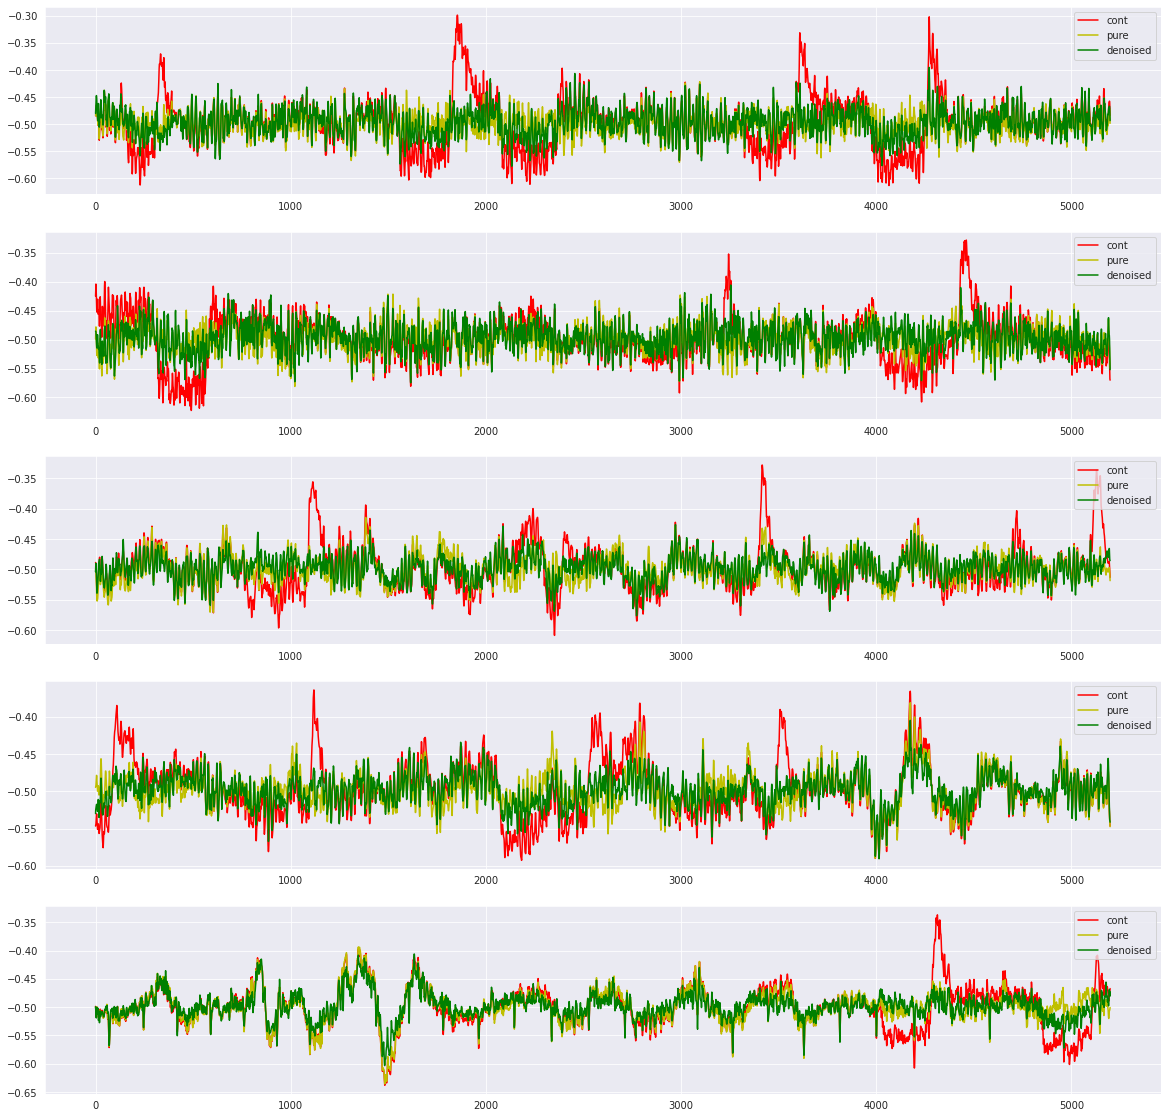

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = eval_cont_eeg[idx_segment, idx_ch, :]
        e_pure = eval_cleaned_eeg[idx_segment, idx_ch, :]
        e_denoised = eval_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        # axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

## Performance metrics

In [ ]:
# # Prepare data for calculating metrics
# reconstructed_pure_EEG = np.array(reconstructed_pure_EEG)
# reconstructed_cont_EEG = np.array(reconstructed_cont_EEG)
# denoised_EEG = np.array(denoised_EEG)
# print(reconstructed_pure_EEG.shape)

# # Hyperparameters for calculating metrics
# list_denoised_EEG_keys = list(selectedLength_contEEG.keys())


# # Prepare data for calculating metrics
# reconstructed_pure_EEG = np.array(grab_children(selectedLength_pureEEG))
# reconstructed_cont_EEG = np.array(grab_children(selectedLength_contEEG))
# reconstructed_denoised_EEG = np.array(denoised_EEG)
# print(reconstructed_denoised_EEG.shape)

# Prepare data for calculating metrics
reconstructed_pure_EEG = de_scaled_pure_eeg
reconstructed_cont_EEG = de_scaled_cont_eeg
reconstructed_denoised_EEG = de_scaled_denoised_eeg
print(reconstructed_denoised_EEG.shape)

# Hyperparameters for calculating metrics
NUMBER_SUBJECTS = reconstructed_denoised_EEG.shape[0]
list_denoised_EEG_keys = list(selectedLength_contEEG.keys())
print(list_denoised_EEG_keys)

# Get some samples
print(reconstructed_pure_EEG[0,0,:10])
print(reconstructed_cont_EEG[0,0,:10])
print(reconstructed_denoised_EEG[0,0,:10])

(54, 19, 5200)
['sim1_con', 'sim2_con', 'sim3_con', 'sim4_con', 'sim5_con', 'sim6_con', 'sim7_con', 'sim8_con', 'sim9_con', 'sim10_con', 'sim11_con', 'sim12_con', 'sim13_con', 'sim14_con', 'sim15_con', 'sim16_con', 'sim17_con', 'sim18_con', 'sim19_con', 'sim20_con', 'sim21_con', 'sim22_con', 'sim23_con', 'sim24_con', 'sim25_con', 'sim26_con', 'sim27_con', 'sim28_con', 'sim29_con', 'sim30_con', 'sim31_con', 'sim32_con', 'sim33_con', 'sim34_con', 'sim35_con', 'sim36_con', 'sim37_con', 'sim38_con', 'sim39_con', 'sim40_con', 'sim41_con', 'sim42_con', 'sim43_con', 'sim44_con', 'sim45_con', 'sim46_con', 'sim47_con', 'sim48_con', 'sim49_con', 'sim50_con', 'sim51_con', 'sim52_con', 'sim53_con', 'sim54_con']
[11.333832  12.315155  10.298584  17.469849  23.683716  26.498322
 23.249756  18.782013  15.634399  13.4114685]
[11.31871986 12.29839897 10.28273773 17.45271301 23.6586895  26.45616531
 23.17921638 18.67058563 15.468853   13.17694283]
[13.92831025 23.3358996  27.49091153 36.73536075 40.0660

In [ ]:
# Save Numpy to Files
"""
5 EOG artifact removal techniques
- 'WT'
- 'ICA'
- 'wICA'
- 'WNN'
- 'SRGAN'
"""
ar_techniques = 'SRGAN'

np.save(
    file=f'Result/before_after_removal/{ar_techniques}_pure_EEG',
    arr=reconstructed_pure_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_cont_EEG',
    arr=reconstructed_cont_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_denoised_EEG',
    arr=reconstructed_denoised_EEG,
    allow_pickle=True, fix_imports=True)

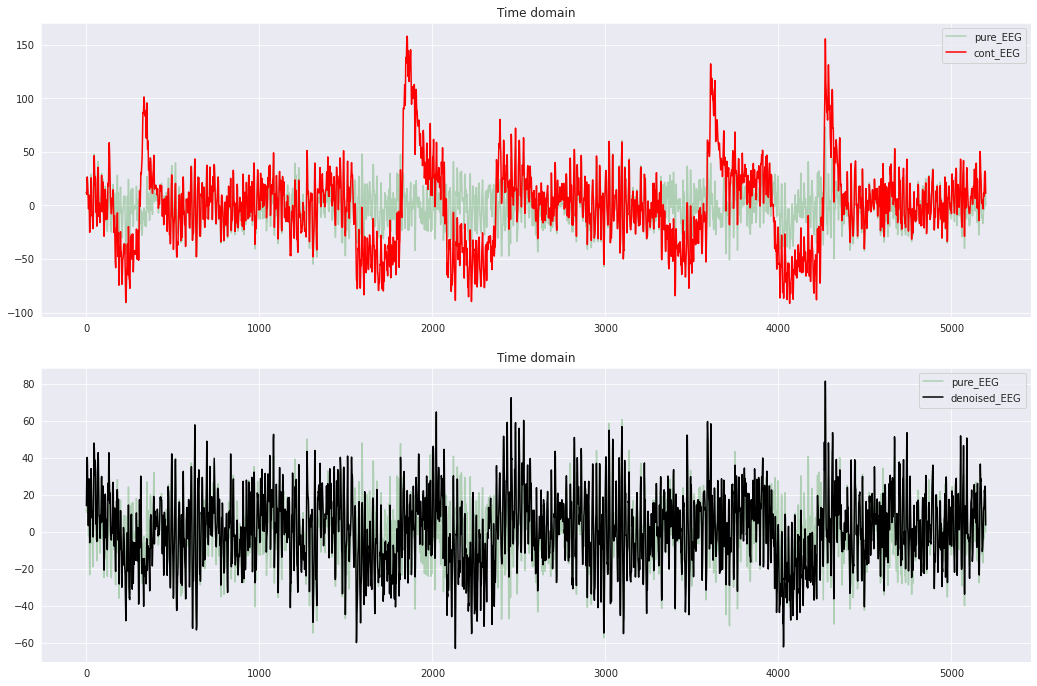

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,10))
    fig.tight_layout(pad=3.0)
    return fig,axs

# Prepare subplots
fig, axs = createSubplot(2)
# Select a subject's electrode
selected_idx_subject = 0
selected_idx_electrode = 0

plt.sca(axs[0])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25)
plt.plot(reconstructed_cont_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="cont_EEG", color="r")
plt.title("Time domain")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25)
plt.plot(reconstructed_denoised_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="denoised_EEG", color="k")

plt.title("Time domain")
plt.legend(loc="upper right")

plt.show()

In [ ]:
def calculate_RMSE(pure_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate RMSE in dB scale (log based E)
    """
    diff_EEG = pure_EEG_e_CH - denoised_EEG_e_CH
    RMSE = np.mean(np.power(diff_EEG,2))
    return RMSE

def calculate_SAR(cont_EEG_e_CH,denoised_EEG_e_CH):
    """
    Calculate Signal to Artifact Ratio (SAR)
    """
    SAR = 10*np.log(np.std(cont_EEG_e_CH) / np.std(cont_EEG_e_CH-denoised_EEG_e_CH))
    return SAR

def calculate_MSC(cont_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    MSC = scipy.signal.coherence(x=cont_EEG_e_CH, y=denoised_EEG_e_CH,
                                 fs=200, window='hann', nperseg=200,
                                 noverlap=None, nfft=None, detrend=False,
                                 axis=-1)
    return MSC

def calculate_PSD(EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    PSD = scipy.signal.welch(x=EEG_e_CH,
                             fs=200, window='hann', nperseg=200, 
                             noverlap=None, nfft=None, detrend=False,
                             scaling='density',
                             axis=-1)
    return PSD

In [ ]:
pure_denoised_RMSE_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_RMSE = []
    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_RMSE = calculate_RMSE(
            pure_EEG_e_CH=manyCH_pureEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_RMSE.append(oneCH_RMSE)

    pure_denoised_RMSE_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# Create DataFrame for RMSE
df_RMSE = pd.DataFrame(data=pure_denoised_RMSE_subjs, 
                      index= EEG_electrodes,
                      columns=pure_denoised_RMSE_subjs.keys())

print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")
df_RMSE

Avg. RMSE of each Electrodes: 
Fp1    124.900901
Fp2    128.700020
F3      30.834853
F4      36.046981
C3       9.644867
C4      14.307880
P3       6.110411
P4      14.555602
O1      31.286546
O2      18.736001
F7      55.001880
F8      57.104735
T3      21.657622
T4      91.821019
T5       6.603357
T6       8.456584
Fz      22.491704
Cz      29.949892
Pz      36.149993
dtype: float64
Grand Avg. RMSE: 39.17688669973808


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,...,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,145.024725,135.612637,124.827614,142.660629,105.785367,180.294749,140.497382,202.188935,84.648920,67.412910,...,71.766661,65.594736,100.125025,72.721802,88.215418,111.138032,109.968708,107.690564,87.694806,129.950097
Fp2,157.993494,147.486302,129.186761,134.070517,115.636074,184.796501,137.549094,196.205854,75.699288,68.919040,...,80.442461,67.635165,110.239710,63.706747,75.006431,113.444725,112.592056,105.954169,100.434479,139.376648
F3,34.491411,35.280614,34.462001,31.095306,19.831665,33.986069,32.616653,42.568834,21.209249,16.111462,...,19.023318,18.355948,21.064874,22.595007,23.880562,30.254953,29.958626,27.688258,24.952999,28.282455
F4,75.250957,47.869060,41.067243,40.094206,31.159488,38.436642,35.626820,40.905514,19.258242,19.400676,...,26.928549,19.803227,39.549223,20.214832,24.858858,31.839772,29.277941,25.975929,30.927556,33.429308
C3,16.979420,13.740152,10.993507,10.121951,5.681242,7.906835,6.514457,9.855740,4.702108,3.616807,...,5.954354,4.534996,5.818008,3.618722,3.836459,5.529399,6.770973,5.640441,9.106114,12.011320
C4,28.669045,18.116766,12.157833,12.869826,13.839120,21.476182,11.832444,13.780925,7.074134,6.429767,...,7.029846,6.249377,9.387327,7.336066,7.188477,8.827623,9.837806,7.896913,13.055471,15.392680
P3,7.635594,6.937998,5.901861,5.482498,6.155283,6.461924,4.294992,5.117107,4.075883,3.443599,...,4.492642,3.213136,7.528487,4.147121,3.594946,4.321415,4.763429,4.901723,4.210207,4.336249
P4,25.885244,18.596837,12.811152,17.023093,16.168178,17.148055,12.717349,14.575663,9.449719,10.152049,...,12.760745,15.066779,11.505012,11.861396,9.546677,12.434141,12.988231,12.800439,11.081153,11.246664
O1,40.627926,37.579395,31.737607,35.943004,33.953620,32.337865,27.873686,28.908658,28.197438,25.091677,...,25.730424,23.303853,25.337528,25.174303,26.146293,29.133983,24.026823,25.677669,28.902442,25.790201
O2,29.410617,24.140031,16.611319,17.209584,13.268790,16.260137,18.103455,17.910565,13.964138,14.507511,...,14.878804,18.338152,18.862055,12.467534,12.916880,13.238017,16.982200,13.471093,17.390191,17.545775


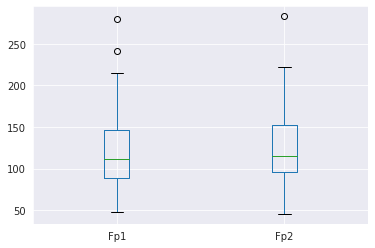

In [ ]:
df_RMSE.copy().transpose().boxplot(['Fp1', 'Fp2'])

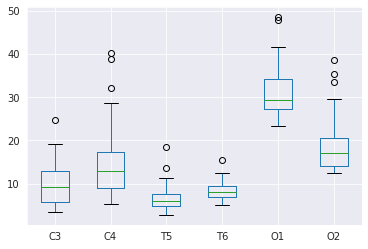

In [ ]:
df_RMSE.copy().transpose().boxplot(['C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

In [ ]:
cont_denoised_SAR_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_SAR = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_SAR = calculate_SAR(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_SAR.append(oneCH_SAR)

    cont_denoised_SAR_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_SAR
    
# Create DataFrame for SAR
df_SAR = pd.DataFrame(data=cont_denoised_SAR_subjs, 
                      index= EEG_electrodes,
                      columns=cont_denoised_SAR_subjs.keys())

print(f"Avg. SAR of each Electrodes: \n{df_SAR.mean(axis=1)}")
print(f"Grand Avg. SAR: {np.mean(df_SAR.mean(axis=1))}")
df_SAR

Avg. SAR of each Electrodes: 
Fp1     2.000815
Fp2     1.649721
F3      5.651145
F4      4.892595
C3      9.223622
C4      8.773635
P3     12.798682
P4     14.999154
O1     12.788713
O2     15.722558
F7      3.973946
F8      4.899350
T3      6.352036
T4      6.689166
T5     12.535644
T6     11.018140
Fz      4.759962
Cz      9.676165
Pz     13.186581
dtype: float64
Grand Avg. SAR: 8.504822673403703


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,...,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,2.606977,2.754158,2.875941,4.031442,4.820274,1.280593,1.926401,2.044039,1.396007,0.923672,...,0.506193,0.788359,0.164962,1.038910,1.078909,1.254171,0.745255,0.941298,1.733743,0.171863
Fp2,2.127010,2.597065,1.801875,3.300003,2.898166,0.731737,1.079743,1.531290,0.781227,0.146539,...,0.772027,0.560958,4.695736,0.726486,0.645831,0.993988,0.199412,0.408424,1.608063,0.332420
F3,6.945752,8.143418,7.601021,8.096277,9.706479,5.168859,7.665870,5.732196,4.028891,3.344178,...,3.125428,1.839020,1.199079,2.952694,3.195580,2.466156,2.633944,2.943927,4.815112,3.860354
F4,8.614855,7.824052,5.963869,7.078729,6.968579,3.635832,5.318801,4.747086,2.699810,2.406278,...,3.062274,1.130200,1.053268,2.837882,2.028866,2.480054,1.023396,1.895423,4.581462,5.631558
C3,11.748127,14.888369,12.712621,14.386393,12.486679,9.074344,11.444949,8.818363,6.157210,5.466581,...,5.948026,4.338984,2.125691,5.473059,5.599150,4.433336,5.651241,5.188375,7.445770,7.185084
C4,11.283402,13.437336,11.008666,12.769219,6.024137,4.740253,10.130730,7.970789,5.905099,6.358317,...,7.163622,4.625008,3.081138,6.682864,5.737195,5.354072,4.859590,4.691295,8.340095,10.899942
P3,19.476080,21.242599,16.443543,17.752562,12.539559,10.483774,12.341499,11.108803,6.985555,7.894442,...,14.447997,12.149304,4.084357,10.039657,9.023537,7.140295,9.690801,9.005211,9.795489,10.576997
P4,17.137352,21.109410,16.261922,17.546973,10.583558,11.052485,16.155229,14.731675,11.398161,12.690834,...,15.932864,14.875108,10.073921,14.811622,13.265666,11.770382,13.618968,11.551972,14.197117,17.284561
O1,16.104143,18.641739,17.727342,18.353848,11.970400,11.373282,15.985580,14.513853,8.995184,9.949250,...,9.051163,9.467155,7.541767,12.669429,12.476298,10.389766,11.898531,10.566288,10.541836,10.577501
O2,17.972273,19.619214,17.741875,17.600023,16.517790,13.570930,17.395146,16.341553,14.693537,16.182532,...,14.576749,12.927211,15.090269,16.166719,15.882884,15.776277,16.150424,13.821151,17.596693,17.906629


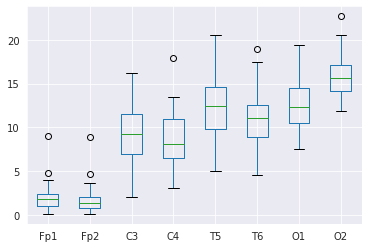

In [ ]:
df_SAR.copy().transpose().boxplot(['Fp1','Fp2','C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

The shape of cont_denoised_MSC_subjs: (54, 19, 2, 101)


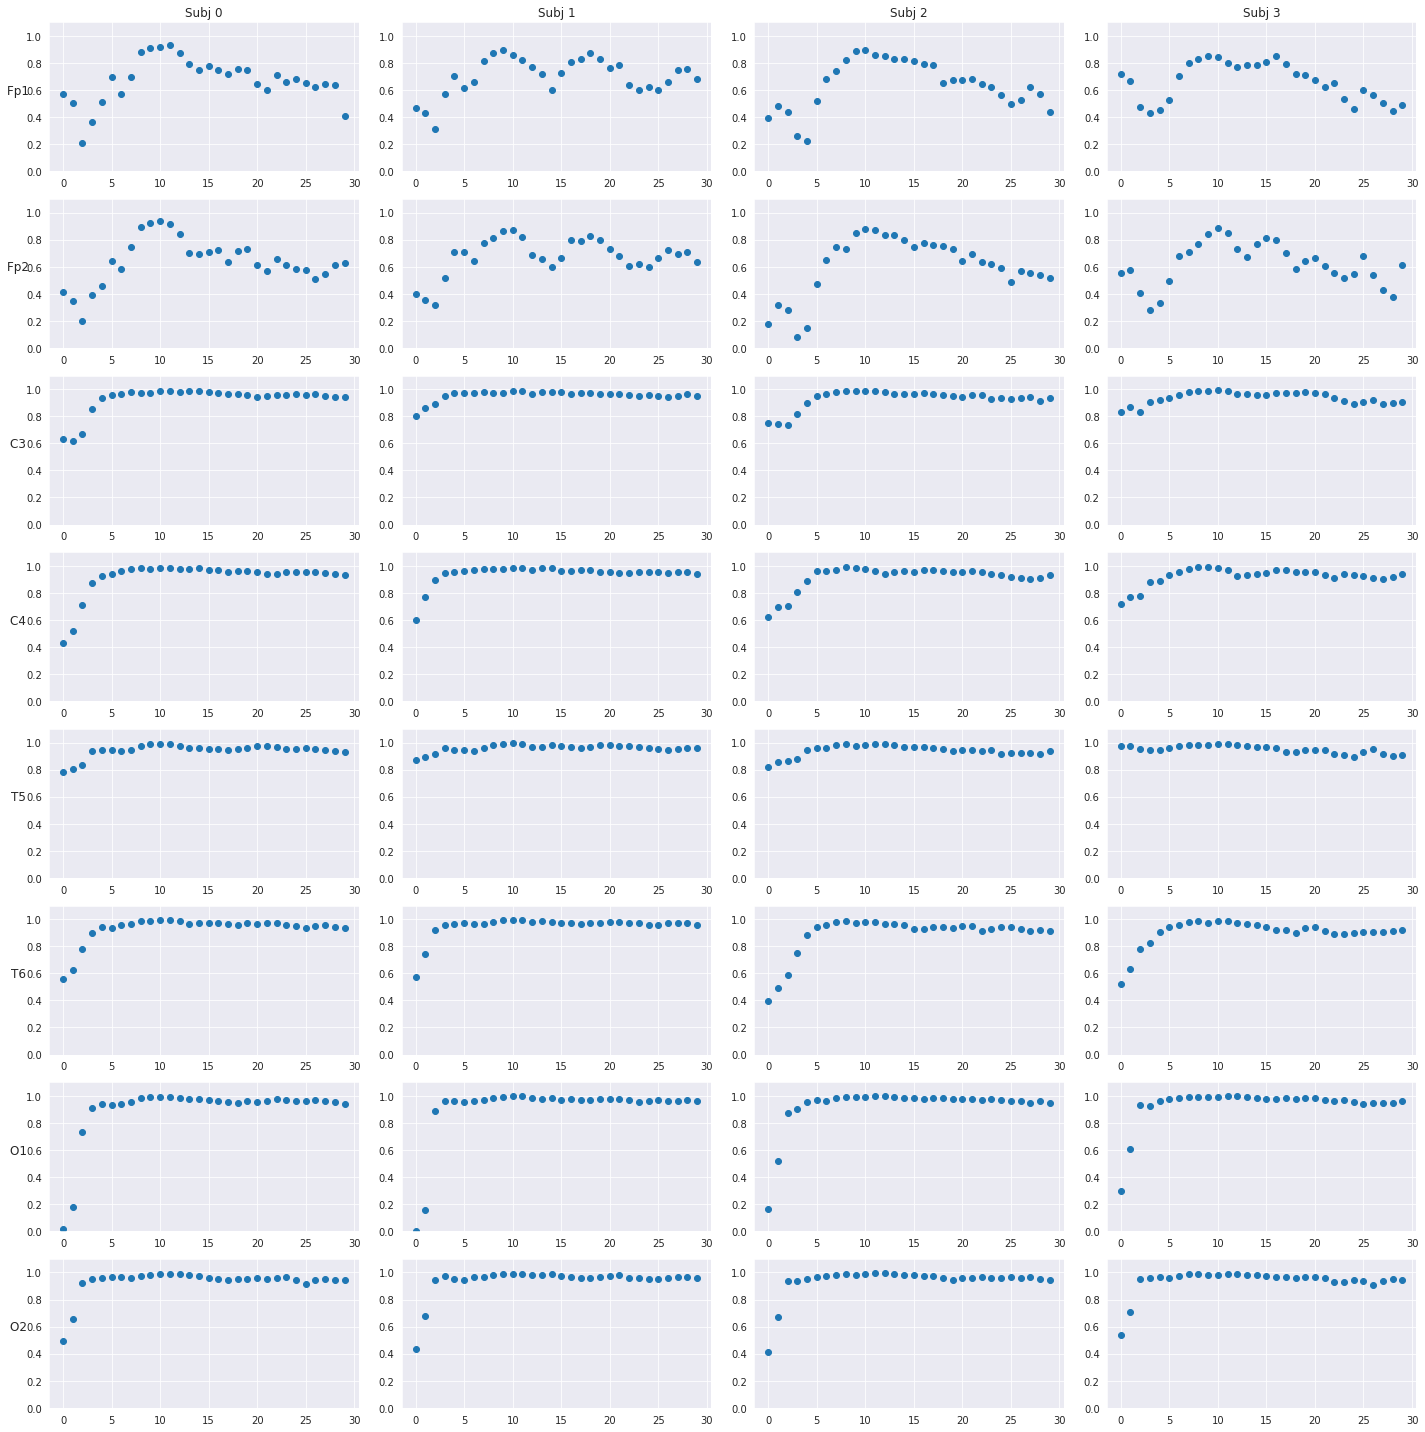

In [ ]:
cont_denoised_MSC_subjs = []

for idx_e_subject in range(number_subjects):
    manyCH_MSC = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_MSC = calculate_MSC(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_MSC.append(oneCH_MSC)

    cont_denoised_MSC_subjs.append(manyCH_MSC)

cont_denoised_MSC_subjs = np.array(cont_denoised_MSC_subjs)
print(f'The shape of cont_denoised_MSC_subjs: {cont_denoised_MSC_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']


# Plot MSC
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].scatter(
        cont_denoised_MSC_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[0,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,0].set_ylim(0,1.1)

    axs[idx_e_ch,1].scatter(
        cont_denoised_MSC_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].set_ylim(0,1.1)

    axs[idx_e_ch,2].scatter(
        cont_denoised_MSC_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].set_ylim(0,1.1)

    axs[idx_e_ch,3].scatter(
        cont_denoised_MSC_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].set_ylim(0,1.1)

fig.tight_layout()
plt.show()

The shape of pure_PSD_subjs: (54, 19, 2, 101)
The shape of cont_PSD_subjs: (54, 19, 2, 101)
The shape of denoised_PSD_subjs: (54, 19, 2, 101)


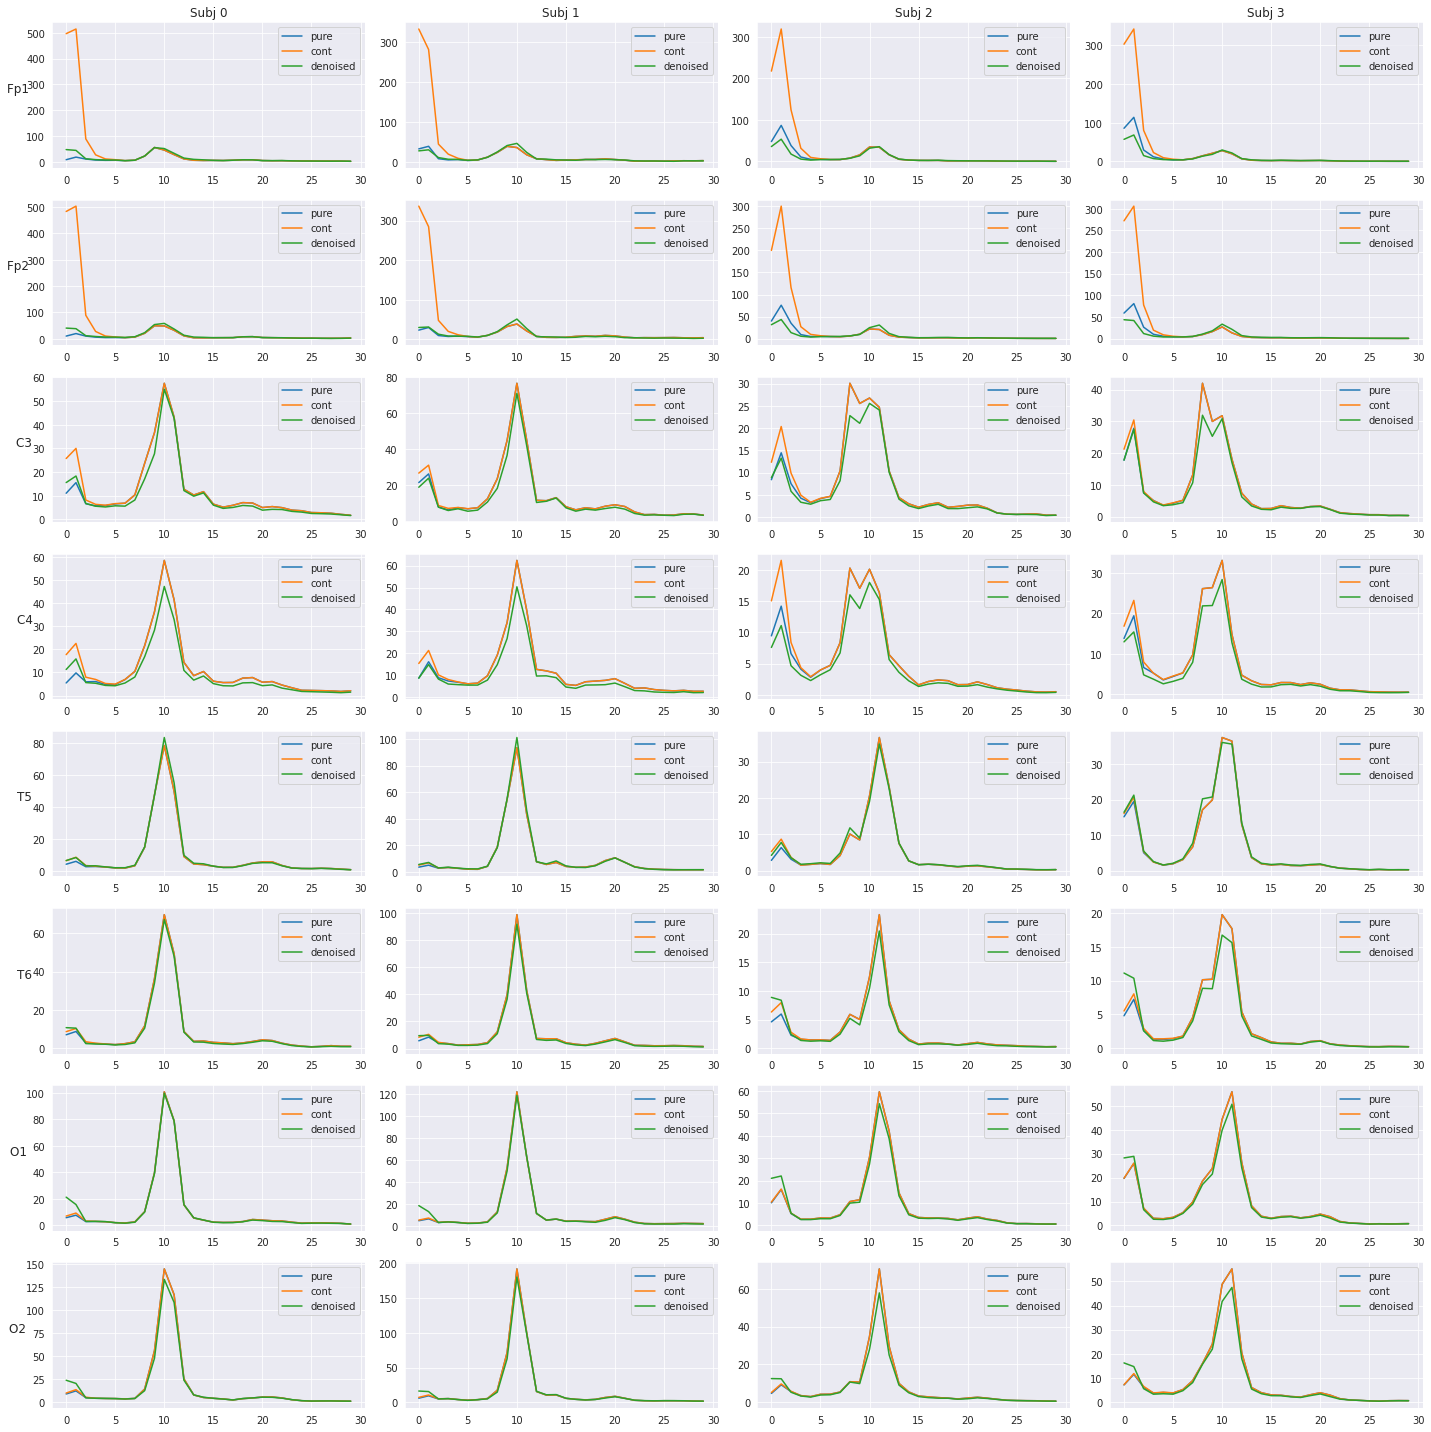

In [ ]:
pure_PSD_subjs = []
cont_PSD_subjs = []
denoised_PSD_subjs = []

for idx_e_subject in range(number_subjects):
    pure_PSD_CHs = []
    cont_PSD_CHs = []
    denoised_PSD_CHs = []

    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_pure_PSD = calculate_PSD(manyCH_pureEEG[idx_channel])
        oneCH_cont_PSD = calculate_PSD(manyCH_contEEG[idx_channel])
        oneCH_denoised_PSD = calculate_PSD(manyCH_denoisedEEG[idx_channel])

        pure_PSD_CHs.append(oneCH_pure_PSD)
        cont_PSD_CHs.append(oneCH_cont_PSD)
        denoised_PSD_CHs.append(oneCH_denoised_PSD)

    pure_PSD_subjs.append(pure_PSD_CHs)
    cont_PSD_subjs.append(cont_PSD_CHs)
    denoised_PSD_subjs.append(denoised_PSD_CHs)

pure_PSD_subjs = np.array(pure_PSD_subjs)
cont_PSD_subjs = np.array(cont_PSD_subjs)
denoised_PSD_subjs = np.array(denoised_PSD_subjs)

print(f'The shape of pure_PSD_subjs: {pure_PSD_subjs.shape}')
print(f'The shape of cont_PSD_subjs: {cont_PSD_subjs.shape}')
print(f'The shape of denoised_PSD_subjs: {denoised_PSD_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']

# Plot PSD
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].plot(
        pure_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        cont_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        denoised_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,1].plot(
        pure_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].plot(
        cont_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].plot(
        denoised_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,2].plot(
        pure_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].plot(
        cont_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].plot(
        denoised_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,3].plot(
        pure_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].plot(
        cont_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].plot(
        denoised_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].legend(['pure', 'cont', 'denoised'])

fig.tight_layout()
plt.show()

# Save metrics

In [ ]:
!pwd
df_RMSE.to_csv(path_or_buf='save_results/06_SRGAN_RMSE.csv', 
               sep=',', float_format=None)
df_SAR.to_csv(path_or_buf='save_results/06_SRGAN_SAR.csv', 
               sep=',', float_format=None)


/content/drive/MyDrive/Colab Notebooks/Thesis_st121166
